# Configuracion de grafica a usar

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# lA ID de la GPU a usar, puede ser desde 0 hasta las N GPU's. Si es -1 significa que es en la CPU
os.environ["CUDA_VISIBLE_DEVICES"]="1";

# Importacion de librerias

In [34]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from IPython.display import display, clear_output

%matplotlib inline
import sys
import seaborn as sns
import plotly
import matplotlib.pyplot as plt
sys.path.append('../')
from Datasets_utils.DatasetsLoader import VideoDataGenerator

# Configuraciones para Tensorflow y Keras

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [5]:
tf.debugging.set_log_device_placement(False)

In [6]:
#Comprobar que estoy ejecutandome en modo eagerly
tf.executing_eagerly()

True

# Carga de Datos

In [7]:
root_path = "/home/jefelitman/DataSets/ucf101/split_1"
root_path

'/home/jefelitman/DataSets/ucf101/split_1'

In [8]:
batch = 30
original_size = [171,128]
size = [112,112]
frames = 16
canales = 3

In [9]:
dataset = VideoDataGenerator(directory_path = root_path, 
                             batch_size = batch, 
                             original_frame_size = original_size, 
                             frame_size=size, 
                             video_frames = frames, 
                             temporal_crop = ('random', 4), 
                             frame_crop = ('random', 2), 
                             shuffle = True, 
                             conserve_original = True)

# Red Neuronal LTC

### Construccion del modelo

In [10]:
#Entrada de la red neuronal
video_shape = tuple([frames]+size+[canales])
dropout = 0.5
entrenamiento = True
lr = 1e-3

In [ ]:
entrada = keras.Input(shape=video_shape,
                     batch_size=batch,
                     name="Input_video")
#Conv1
x = keras.layers.Conv3D(filters=64, kernel_size=3, padding="same", activation="relu", use_bias=False)(entrada)
x = keras.layers.MaxPool3D(pool_size=(1,2,2),strides=(1,2,2))(x)

#Conv2
x = keras.layers.Conv3D(filters=128, kernel_size=3, padding="same", activation="relu", use_bias=False)(x)
x = keras.layers.MaxPool3D(pool_size=(2,2,2),strides=(2,2,2))(x)

#Conv3
x = keras.layers.Conv3D(filters=256, kernel_size=3, padding="same", activation="relu", use_bias=False)(x)
x = keras.layers.MaxPool3D(pool_size=(2,2,2),strides=(2,2,2))(x)

#Conv4
x = keras.layers.Conv3D(filters=256, kernel_size=3, padding="same", activation="relu", use_bias=False)(x)
x = keras.layers.MaxPool3D(pool_size=(2,2,2),strides=(2,2,2))(x)

#Conv5
x = keras.layers.Conv3D(filters=256, kernel_size=3, padding="same", activation="relu", use_bias=False)(x)
x = keras.layers.MaxPool3D(pool_size=(2,2,2),strides=(1,1,1))(x)

#fc6
x = tf.reshape(tensor=x, shape=[batch,-1], name="Aplanado")
x = keras.layers.Dense(2048, activation="relu")(x)
x = keras.layers.Dropout(dropout)(x, training=entrenamiento)

#fc7
x = keras.layers.Dense(2048, activation="relu")(x)
x = keras.layers.Dropout(dropout)(x, training=entrenamiento)

#fc8
salidas= keras.layers.Dense(len(dataset.to_class), activation="softmax")(x)

ltc = keras.Model(entrada, salidas, name="LTC")

In [11]:
#Optimizador del modelo
optimizador = keras.optimizers.SGD(learning_rate=lr)
perdida = keras.losses.SparseCategoricalCrossentropy()

In [ ]:
#keras.utils.plot_model(ltc, 'LTC.png', show_shapes=True)

In [12]:
ltc = keras.models.load_model('/home/jefelitman/Saved_Models/LTC_112x112x16_rgb_batch30/ltc.h5')

In [13]:
ltc.summary()

Model: "LTC"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_video (InputLayer)     [(30, 16, 112, 112, 3)]   0         
_________________________________________________________________
conv3d (Conv3D)              (30, 16, 112, 112, 64)    5184      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (30, 16, 56, 56, 64)      0         
_________________________________________________________________
conv3d_1 (Conv3D)            (30, 16, 56, 56, 128)     221184    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (30, 8, 28, 28, 128)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (30, 8, 28, 28, 256)      884736    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (30, 4, 14, 14, 256)      0       

### Entrenamiento de la red

In [14]:
def precision(y, y_predicho):
    clases = tf.argmax(y_predicho, axis=1)
    comparaciones = tf.equal(y, clases)
    return tf.reduce_mean(tf.cast(comparaciones, tf.int32))

In [15]:
step = 1
train_epoch = 1
train_loss = []
train_accuracy = []
maximo = -1
step_max = 0

In [16]:
while train_epoch < 5:
    if step % 1000 == 0:
        ltc.save('/home/jefelitman/Saved_Models/LTC_112x112x16_rgb_batch30/ltc.h5')
        print('Modelo salvado en la iteracion: {i}'.format(i=step))
        
    if step == 80000 or step == 125000:
        lr = lr * 0.1
        optimizador = keras.optimizers.SGD(learning_rate=lr)
    
    if dataset.train_batch_index == dataset.train_batches:
        train_epoch += 1
    
    batch, labels = dataset.get_next_train_batch(canales)
    
    with tf.GradientTape() as tape:
        predicciones = ltc(batch)
        valor_perdida = perdida(labels, predicciones)
    
    with tf.device('/CPU:0'):
        train_loss.append(valor_perdida)    
        train_accuracy.append(precision(labels, predicciones))

        if train_accuracy[-1] > maximo:
            maximo = train_accuracy[-1]
            step_max = step

        clear_output(wait=True)
        print("Step: ",step)
        print("Train Epoch: ",train_epoch, " Train batch: ",dataset.train_batch_index,"/",dataset.train_batches)
        print("Train_Loss: ",train_loss[-1].numpy()," Train_Acuraccy: ",train_accuracy[-1].numpy())
        print("Tain_max_Acuraccy: {m} at the step: {s}".format(m=maximo, s=step_max))
        
    grads = tape.gradient(valor_perdida, ltc.trainable_weights)
    
    optimizador.apply_gradients(zip(grads, ltc.trainable_weights))
    
    step += 1

Step:  58077
Train Epoch:  5  Train batch:  1 / 14519
Train_Loss:  0.053884998  Train_Acuraccy:  0
Tain_max_Acuraccy: 1 at the step: 13146


KeyboardInterrupt: 

### Graficas de los resultados de entrenamiento

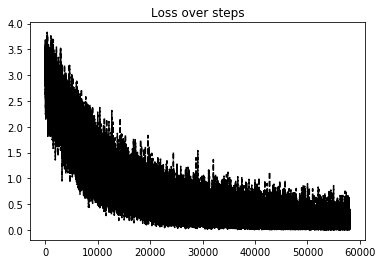

In [42]:
fig = plt.figure()
plt.plot(range(len(train_loss)), train_loss,'k--')
plt.title('Loss over steps')
plt.show()
fig.savefig('/home/jefelitman/Saved_Models/LTC_112x112x16_rgb_batch30/train_loss.png')

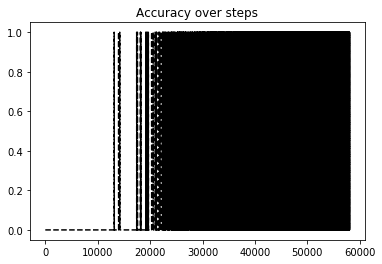

In [43]:
fig = plt.figure()
plt.plot(range(len(train_accuracy)), train_accuracy,'k--')
plt.title('Accuracy over steps')
plt.show()
fig.savefig('/home/jefelitman/Saved_Models/LTC_112x112x16_rgb_batch30/train_accuracy.png')

### Evaluacion del entrenamiento

In [30]:
ltc.get_layer(index=13)._

SyntaxError: can't assign to function call (<ipython-input-30-436adb5f60eb>, line 1)

In [ ]:
test_epoch = 1
test_loss = []
test_accuracy = []
entrenamiento = False
while test_epoch == 1:
    
    if dataset.test_batch_index == dataset.test_batches:
        test_epoch += 1
    
    batch, labels = dataset.get_next_test_batch(canales)
    
    with tf.GradientTape() as tape:
        predicciones = ltc(batch)
        valor_perdida = perdida(labels, predicciones)
    
    with tf.device('/CPU:0'):
        test_loss.append(valor_perdida)    
        test_accuracy.append(precision(labels, predicciones))
    
        clear_output(wait=True)
        print("Step: ",step)
        print("Test Epoch: ",test_epoch, " Test batch: ",dataset.test_batch_index,"/",dataset.test_batches)
        print("Test_Loss: ",test_loss[-1].numpy()," Test_Acuraccy: ",test_accuracy[-1].numpy())
    
    step += 1

Step:  63450
Test Epoch:  1  Test batch:  5374 / 5689
Test_Loss:  2.466967  Test_Acuraccy:  0


### Graficas de los resultados de entrenamiento

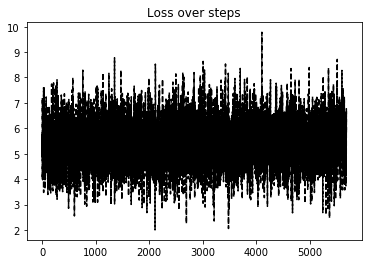

In [46]:
fig = plt.figure()
plt.plot(range(len(test_loss)), test_loss,'k--')
plt.title('Loss over steps')
plt.show()
fig.savefig('/home/jefelitman/Saved_Models/LTC_112x112x16_rgb_batch30/test_loss.png')

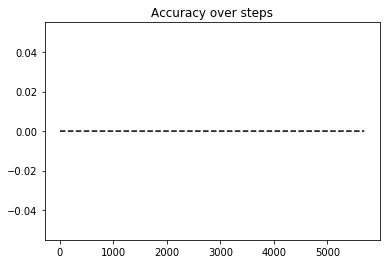

In [47]:
fig = plt.figure()
plt.plot(range(len(test_accuracy)), test_accuracy,'k--')
plt.title('Accuracy over steps')
plt.show()
fig.savefig('/home/jefelitman/Saved_Models/LTC_112x112x16_rgb_batch30/test_accuracy.png')